In [1]:
from project_libraries import *
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
import seaborn as sns
import timeit
from sklearn.model_selection import KFold

Using TensorFlow backend.


## Loading the data

The data consists of 48x48 pixel grayscale images of faces. 


Generally facial expression into one of seven categories that are : 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
 

The training set consists of 28,709 examples and the public test set consists of 3,589 examples.


In [2]:
# loading the data
data = './sa.csv'
# In the dataset lableling map is 0 as anger, 1=Disgust, 2=Fear.. etc.
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
# the dataset has headers like emotion, pixels and useage
headers =['emotion','pixels','usage']
df=pd.read_csv(data ,names=headers, na_filter=False)
im=df['pixels']
# head data 
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


## Data visualization
By this can able understand the dataset, number of data for each class

In [3]:
df = pd.read_csv("./sa.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


<AxesSubplot:xlabel='emotion', ylabel='count'>

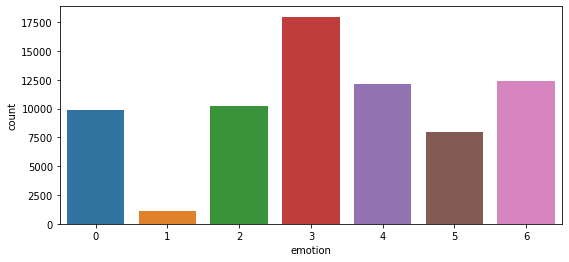

In [4]:
plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=df)

## Analyze the data
Lets now analyze how images in the dataset look like how much data is present for each class and how many number of classes are present.

In [5]:
# Function dataset file is for defining the number of classes
def Datasetfile(filname):
    # images are 48x48
    # N = 35887
    Y = [] # y is used name classes
    X = [] # x is used for remaining data
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])
    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [7]:
X, Y = Datasetfile(data)
name_class = set(Y)
print("The name of classes")
if 0 in name_class:
    print("Anger")
    if 1 in name_class:
        print("Disgust")
        if 2 in name_class:
            print("Fear")
            if 3 in name_class:
                print("Happy")
                if 4 in name_class:
                    print("Sad")
                    if 5 in name_class:
                        print("Suprise")
                        if 6 in name_class:
                            print("Neutral")
num_class = len(name_class)
print("The number of classes are:",num_class)

The name of classes
Anger
Disgust
Fear
Happy
Sad
Suprise
Neutral
The number of classes are: 7


In [8]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

splitting the data into train data and test data.
Using the 90% data for the training and remaining for testing.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

## The model:
With the help of CNN using 6 convolutional layers including batch normalization, activation, max pooling, dropout layers and flatten layyers. 2 full connected dense layers and finally dense layer.

In [10]:
def my_model():
    
    # Sequential is allow the build the model layers by layers
    model = Sequential()
    # input shape 
    input_shape = (48,48,1)
    # For the output volume size matches the input volume size, by setting the value to the “same”.
    padding = 'same'
    # activation Relu will help to bring the non linearity in the model
    activation = 'relu'
    #technique to coordinate the update of multiple layers in the modeland also accelerate learning process
    #Normalization = BatchNormalization()
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation=activation, padding=padding))
    model.add(Conv2D(64, (5, 5), activation=activation, padding=padding))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (5, 5),activation=activation, padding=padding))
    model.add(Conv2D(128, (5, 5),activation=activation, padding=padding))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3),activation=activation, padding=padding))
    model.add(Conv2D(256, (3, 3),activation=activation, padding=padding))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten helps converting the data into 1-dimension array. for inputting full connected dense layer
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu')) # activation function
    # The dropped while training this effect makes network less sensitive, also reduce the problem - less overfit
    model.add(Dropout(0.25))
    
    model.add(Dense(7))
    model.add(Activation('softmax'))
    # compile the model with the parameters.
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

    return model
# renaming the my_model as model
model=my_model()
# model summary
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       409728    
_____________

In [ ]:
#Define the K-fold Cross Validator
num_folds = 3
acc_per_fold = 0;
loss_per_fold = 0;

path_model = 'model_filter.h5'
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_train, y_train):

  # Define the model architecture
  model = my_model()
    
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  # Fit data to model
  history = model.fit(x=X_train, y=y_train,epochs=1,batch_size=64,verbose=1,validation_data=(X_test,y_test),shuffle=True, callbacks=[ModelCheckpoint(filepath=path_model, verbose=1, save_best_only=True),])


  # Generate generalization metrics
  scores = model.evaluate(X_test, y_test, verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Train on 64596 samples, validate on 7178 samples
Epoch 1/1
17344/64596 [=======>......................] - ETA: 33:37 - loss: 1.8199 - acc: 0.2858

In [ ]:
# for understanding the time consuming of the model, 
# starting the time
start = timeit.default_timer()
path_model='model_filter.h5' # saving model
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate at 0.001
# fit the model
# parameter are x as x train data
# y as y train data
# batch size is 64, which means it take 64 samples from the dataset and train network. the defult value is 32, if its 64,128,256 are good for the model
# epoches is 20
# for validation data we are using X_test and Y_test.
h=model.fit(x=X_train, y=y_train,epochs=20,batch_size=64,verbose=1,validation_data=(X_test,y_test),shuffle=True, callbacks=[ModelCheckpoint(filepath=path_model, verbose=1, save_best_only=True),])
# time is stop at the end of all the epoches
stop = timeit.default_timer()
# printing the time 
print('Time: ', stop - start) 

## Model evaluation

In [ ]:

# evaluting the model with x_test and y_test.
test_eval = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Graphical Representation of model accuracy and model loss for both training and testing

In [ ]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()